시계열 데이터 생성하기 
- 참고: https://colab.research.google.com/drive/1uO3Ep1GNB0GMEuXnzy1eqvX9ezovHFnm#scrollTo=6XnN5vSsye2l

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Generate the sine curve
x = np.linspace(-2*np.pi, 2*np.pi, 1000)
y = np.sin(x)

# Create the dataset
df = pd.DataFrame({'x': x, 'y': y})

# Split the dataset into training and testing sets
test_length = 200
train_df = df[:-test_length]  # 처음부터 뒤에서 200번째(=800번째까지)
test_df = df[-test_length:]  # 뒤에서 200번째부터(800번째부터) 마지막까지

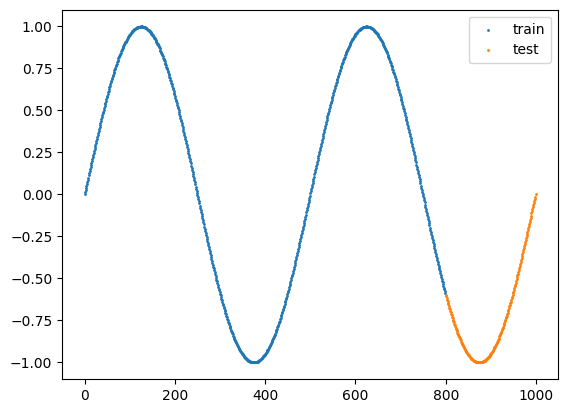

In [3]:
# Visualize data
# scatter(x, y, s=marker size, c=color, label=for legend )
plt.scatter(range(len(train_df)), train_df.y, s = 1, label = "train")
plt.scatter(range(len(train_df), len(train_df)+len(test_df)), test_df.y, s=1, label = "test")
plt.legend()
plt.show()

### Autoregression
- 데이터의 간격이 일정한 경우 (시계열이라면 x값의 단위, 즉 데이터의 주기가 일정해야 함.), 
- `window_size`만큼의 데이터(y값)를 보고, `prediction_size`만큼의 데이터(y값)를 예측하는 문제
- 시계열 데이터에서 x값은 항상 시간이기 때문에 (초, 분, 시, 일, 주, 월, 분기, 년 등등) y값을 들고 예측을 함. 
- autoregression은 다음 주기의 데이터가 이전 주기의 데이터에 영향을 받는 경우임. 
- 따라서, window size만큼의 기간에 대한 y값(과거)을 가지고, prediction size만큼의 y값(미래)을 예측하는 것. 

In [4]:
from torch.utils.data import Dataset, DataLoader

# timeseries용 dataset클래스를 새로 생성 (마치 TensorDataset사용했던 것 처럼!)
class TimeseriesDataset(Dataset):
    def __init__(self, data, window_size = 10, prediction_size = 5):
        self.data = data
        self.window_size = window_size
        self.prediction_size = prediction_size
    
    def __len__(self):
        return len(self.data) - self.window_size - self.prediction_size
    
    def __getitem__(self, idx):
        input = self.data[idx:(idx+self.window_size)]  # 주어진 시간대의 입력 데이터만 
        target = self.data[(idx + self.window_size):(idx + self.window_size + self.prediction_size)] # 그 다음 주기, 예측하려는 미래 값
        return input, target

### 데이터 로드 
- Dataset 불러오기 (train, test)
- 원하는 Batch 사이드 별로 불러오기 위해 Dataloader에 넣기

In [5]:
window_size = 10
prediction_size = 5

trn_ds = TimeseriesDataset(train_df.y.to_numpy(dtype=np.float32), window_size, prediction_size)
tst_ds = TimeseriesDataset(df.y.to_numpy(dtype=np.float32)[-test_length-window_size:],
  window_size,
  prediction_size) # [-210:] 790번째부터 마지막까지

trn_dl = DataLoader(trn_ds, shuffle=True, batch_size = 32)
tst_dl = DataLoader(tst_ds, shuffle=False, batch_size = len(tst_ds))


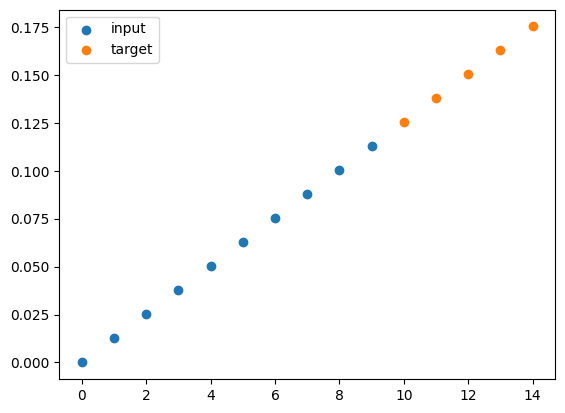

In [6]:
# Visualize dataset 

input, target = trn_ds[0]  # idx = 0
plt.scatter(range(len(input)), input, label='input')   # window_size
plt.scatter(range(len(input), len(input) + len(target)), target, label='target')   # prediction_size
plt.legend()
plt.show()

In [7]:
input.shape

(10,)

In [8]:
target.shape

(5,)

### Task 1: Neural Network 구성해서, trn_ds로 학습 시킨 뒤에, tst_ds로 테스트
- input dim: window_size
- output dim: prediction_size
loss: MSE
metric: MAE

In [9]:
# ------------------ 모델 설계 ----------------- # 
# nn 모델 정의 (init, forward)
# model.to(device)
import torch
import torch.nn as nn 
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, activation = F.relu):
        super().__init__()
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)
        self.activation = activation
    
    def forward(self, x):
        x = self.lin1(x)
        x = self.activation(x)
        x = self.lin2(x)
        return F.tanh(x)

device = "cpu"
model = ANN(input_dim=window_size, output_dim=prediction_size).to(device)

In [10]:
# ------------------ 모델 학습, 최적화 ----------- # 
# loss function
# optimizer
# train 함수 정의(dataloader, model, loss, optimizer)
	# batch size별로 train loop 돌기
		# compute prediction error
		# backpropagation
# test 셋에서도 학습 잘 되는지 확인할 함수 정의(dataloader, model, loss)
	# batch size를 테스트셋 통으로 설정해서 돌리기
		# with torch.inference (optimize 하지 않고 확인: no gradient)
			# loss or metric 계산
# 학습 loop 돌기 (epoch 설정: epoch마다 모델은 파라미터를 학습하고 업데이트함)
# 원하는 모델을 torch.save 
# 나중에 해당 모델을 load해서 prediction을 얻을 수 있음.	

In [11]:
loss_function = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
metric = F.l1_loss # mae

In [12]:
# train 함수 for one epoch
def train(dataloader, model, loss_function, optimizer):
    model.train() # train 모드 진입
    total_loss = 0. # initialize 
    for input,target in dataloader: # dataloader에서 알아서 batch별로 꺼내올거임
        input, target = input.to(device), target.to(device)
        # compute prediction error
        pred = model(input)
        loss = loss_function(pred, target)
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss 직접 계산
        total_loss += loss.item()*len(pred)  # loss.item() loss for every batch 
    return total_loss/len(dataloader.dataset) # 평균 loss값

# test 셋에 넣어서 바로바로 metric 확인해볼 용도, test셋에서도 학습 잘 되는지 확인부터 해야하니까
def test(model, input, target, loss_function, metric, return_pred:bool=False):  # return_pred이 True일때만, prediction값 return
    model.eval() # eval 모드 진입
    with torch.inference_mode():   ################ 
        # TODO 질문: # https://colab.research.google.com/drive/1uO3Ep1GNB0GMEuXnzy1eqvX9ezovHFnm#scrollTo=VgDZYq-uFhy-
        # compute prediction error
        pred = model(input.to(device))
        tst_loss = loss_function(pred, target.to(device)).item()
        # metric도 넣어서 평가하자
        tst_mae = metric(pred, target.to(device)).item()
        # df_metric = pd.DataFrame([loss, mae], index = ["tst_loss: MSE", "tst_metric: MAE"])
        pred_np = pred.numpy()  ### prediction 값 내보내기 위함
    if return_pred:
        return tst_loss, tst_mae, pred_np
    return tst_loss, tst_mae
        

In [13]:
from tqdm.auto import trange # for progress bar visualization

model = ANN(input_dim = window_size, output_dim= prediction_size, hidden_dim=128, activation=F.relu)
model.to(device)

loss_function = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
metric = F.l1_loss # mae

epochs = 2000
pbar = trange(epochs)
for i in pbar:
    trn_mse = train(dataloader=trn_dl, model=model, loss_function=loss_function, optimizer=optimizer)
    input, target = next(iter(tst_dl))  ### test함수에서 dataloader 따로 가져오는 loop부분이 없었음. 여기에서 처리하는 것 같다.
    # iter()는 데이터 로더를 iterable 객체로 만들어줌. 이때, test셋이기 때문에 따로 batch로 쪼개서 가져오는 게 아니라, 
    # 데이터셋 전체를 통으로 가져옴 (그래야 전체 테스트 데이터셋에서 모델이 얼마나 잘 수행되는지를 빠르게 평가할 수 있음)
    # next()는 iterable 객체에서 다음 요소를 가져오는 것. 여기에서는 통으로 가져온 데이터를 한 번에 모델에 전달해서 평가 수행
    tst_loss, tst_mae = test(model = model, input=input, target=target, loss_function = loss_function, metric = metric)
    
    pbar.set_postfix({"trn_mse":trn_mse, "tst_mse": tst_loss, "tst_mae": tst_mae})


  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
input, target = next(iter(tst_dl))
tst_loss, tst_mae, pred_np = test(model = model, input=input, target = target, loss_function = loss_function, metric = metric, return_pred=True)

In [15]:
input.shape

torch.Size([195, 10])

In [16]:
pred_np.shape

(195, 5)

In [17]:
target.shape

torch.Size([195, 5])

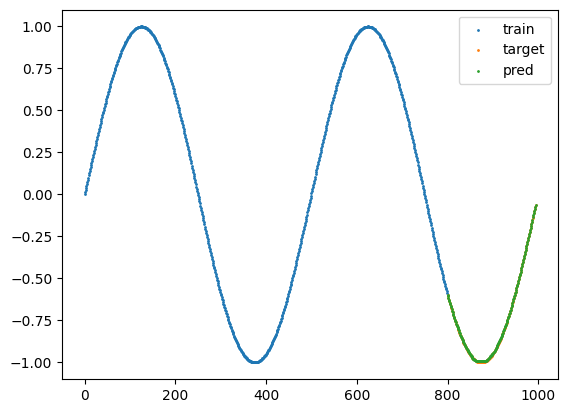

In [18]:
# visualization with predictions 
plt.scatter(range(len(train_df)), train_df.y, s = 1, label = "train")
plt.scatter(range(len(train_df), len(train_df)+len(target)), target[:,0], s=1, label = "target") # 실제 값
plt.scatter(range(len(train_df), len(train_df)+len(pred_np)), pred_np[:,0], s=1, label = "pred")
plt.legend()
plt.show()

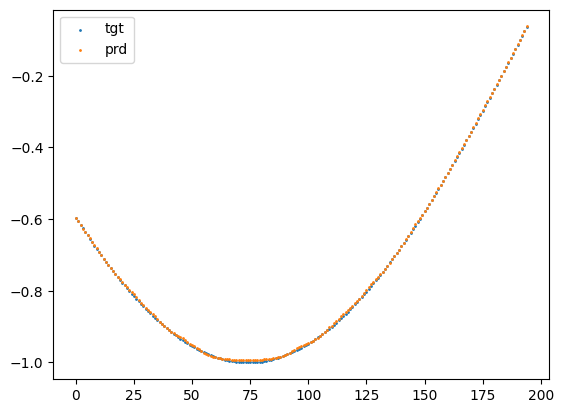

In [19]:
# plt.scatter(range(len(train_df)), train_df.y, s=1, label='trn')
plt.scatter(range(len(target)), target[:,0], s=1, label='tgt')
plt.scatter(range(len(pred_np)), pred_np[:,0], s=1, label='prd')
plt.legend()
plt.show()

### Task 2 
학습된 모델을 사용하여 장기예측 해보기.

장기예측 방법: tst_ds를 사용하지 않고, trn_ds의 마지막 부분을 concatenate하여 input으로 사용하고, prediction 값을 다시 concatenate하여 input으로 사용하는 것을 반복한다.

In [26]:
preds = []

input, target = tst_ds[0]
input = torch.tensor(input)

In [27]:
input

tensor([-0.4904, -0.5014, -0.5122, -0.5230, -0.5336, -0.5442, -0.5548, -0.5652,
        -0.5755, -0.5857])

In [28]:
model.eval()
for _ in range(int(test_length/5)):
    with torch.inference_mode():
        pred = model(input.to(device))
    input = torch.concat([input, pred])[-window_size:]
    preds.append(pred)
preds = np.concatenate(preds)

In [29]:
preds.shape

(200,)

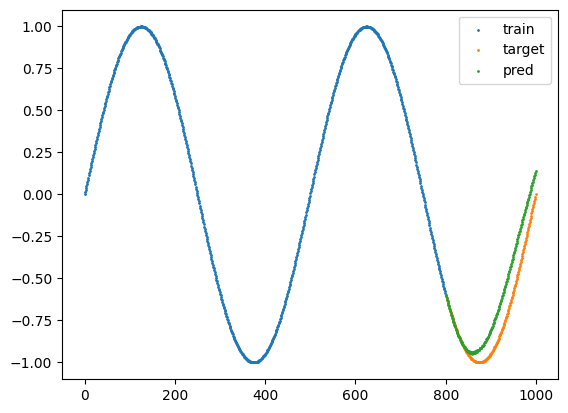

In [30]:
plt.scatter(range(len(train_df)), train_df.y, s=1, label='train')
plt.scatter(range(len(train_df), len(train_df)+len(test_df)), test_df.y, s=1, label='target')
plt.scatter(range(len(train_df), len(train_df)+len(test_df)), preds, s=1, label='pred')
plt.legend()
plt.show()